# Analysis of in-built metric with ci_hsc_gen3

This notebook was adapted from [another dm notebook](https://github.com/yalsayyad/dm_notebooks/blob/master/examples/ComputationalPerf.ipynb).

In [1]:
from lsst.daf.butler import Butler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Change for your specifics here
butler_path =  '/sps/lsst/users/abernard/ci_hsc_gen3/DATA/'
collections_path = ['HSC/runs/ci_hsc_resource_usage/20240807T151456Z']

In [3]:
butler = Butler(butler_path, collections=collections_path)
assert all(c in butler.registry.queryCollections() for c in collections_path), ("Collection in **collections_path** not found through the butler.") 

In [4]:
res = butler.registry.queryDatasetTypes()
resList = list(set(res))
[r.name for r in resList if r.name.endswith('usage')]

['plot_CircAp25_sub_PSF_meas_scatter_visit_resource_usage',
 'plot_wFit_CModel_resource_usage',
 'forcedPhotDiffim_resource_usage',
 'plot_xFit_PSF_resource_usage',
 'plot_CircAp12_sub_PSF_all_scatter_visit_resource_usage',
 'plot_yFit_PSF_resource_usage',
 'sourceObjectMatch_resource_usage',
 'analyzeMatchedPreVisitCore_resource_usage',
 'plot_CircAp12_sub_PSF_meas_sky_stars_visit_resource_usage',
 'plot_CircAp12_sub_PSF_gals_scatter_visit_resource_usage',
 'transformForcedSourceOnDiaObjectTable_resource_usage',
 'plot_CircAp25_sub_PSF_all_scatter_visit_resource_usage',
 'makePreliminaryVisitTable_resource_usage',
 'plot_astromRefCat_scatter_visit_dDec_resource_usage',
 'match_astromRefCat_visit_resource_usage',
 'transformDiaSourceCat_resource_usage',
 'plot_shapeSizeFractionalDiff_scatter_resource_usage',
 'plot_shapeSizeFractionalDiff_scatter_visit_resource_usage',
 'analyzeMatchedVisitCore_resource_usage',
 'plot_shapeSize_scatter_visit_resource_usage',
 'plot_ri_gr_cmodel_resourc

In [5]:
quantileList = []
for rname in [r.name for r in resList if r.name.endswith('usage')]:
    parq = butler.get(rname)
    df = parq.quantile([0,0.01,0.05,.32,.50,.68,.95,.99, 1], numeric_only=True).reset_index()
    df['task'] = rname.replace('_resource_usage', '')
    df['quanta'] = len(parq)
    df['integrated_runtime'] = parq["run_time"].sum()
    quantileList.append(df[["index", "quanta", "task", "memory", "init_time", "run_time", 'integrated_runtime']])

In [6]:
qq = pd.concat(quantileList)
qq["memoryGB"] = qq['memory']/(2**30)
qq['integrated_runtime_hrs'] = qq['integrated_runtime']/3600.
##pd.set_option('display.max_rows', 1200)
##qq

In [ ]:
qq['task-quanta'] = qq['task'] + ' ' + qq['quanta'].apply(lambda x: str(x))
ax = sns.catplot(data=qq[~qq.task.str.startswith("plot_")].sort_values('integrated_runtime_hrs'), y="task-quanta", x="run_time", hue="integrated_runtime_hrs", height=30)
plt.show()
#plt.savefig('runtime.png')

In [8]:
memoryGB = pd.pivot_table(qq, values='memoryGB', columns=['index'], index=['task'])
runtime = pd.pivot_table(qq, values='run_time', columns=['index'], index=['task'])
memoryGB = memoryGB.add_prefix('memGB_')
runtime = runtime.add_prefix('runtime_')

In [9]:
memrun = pd.merge(memoryGB.reset_index(), runtime.reset_index())
memrun = pd.merge(qq[['task','quanta', 'integrated_runtime_hrs']].drop_duplicates().sort_values('task'), memrun)

In [10]:
pd.set_option('display.max_rows', 150)
#memrun

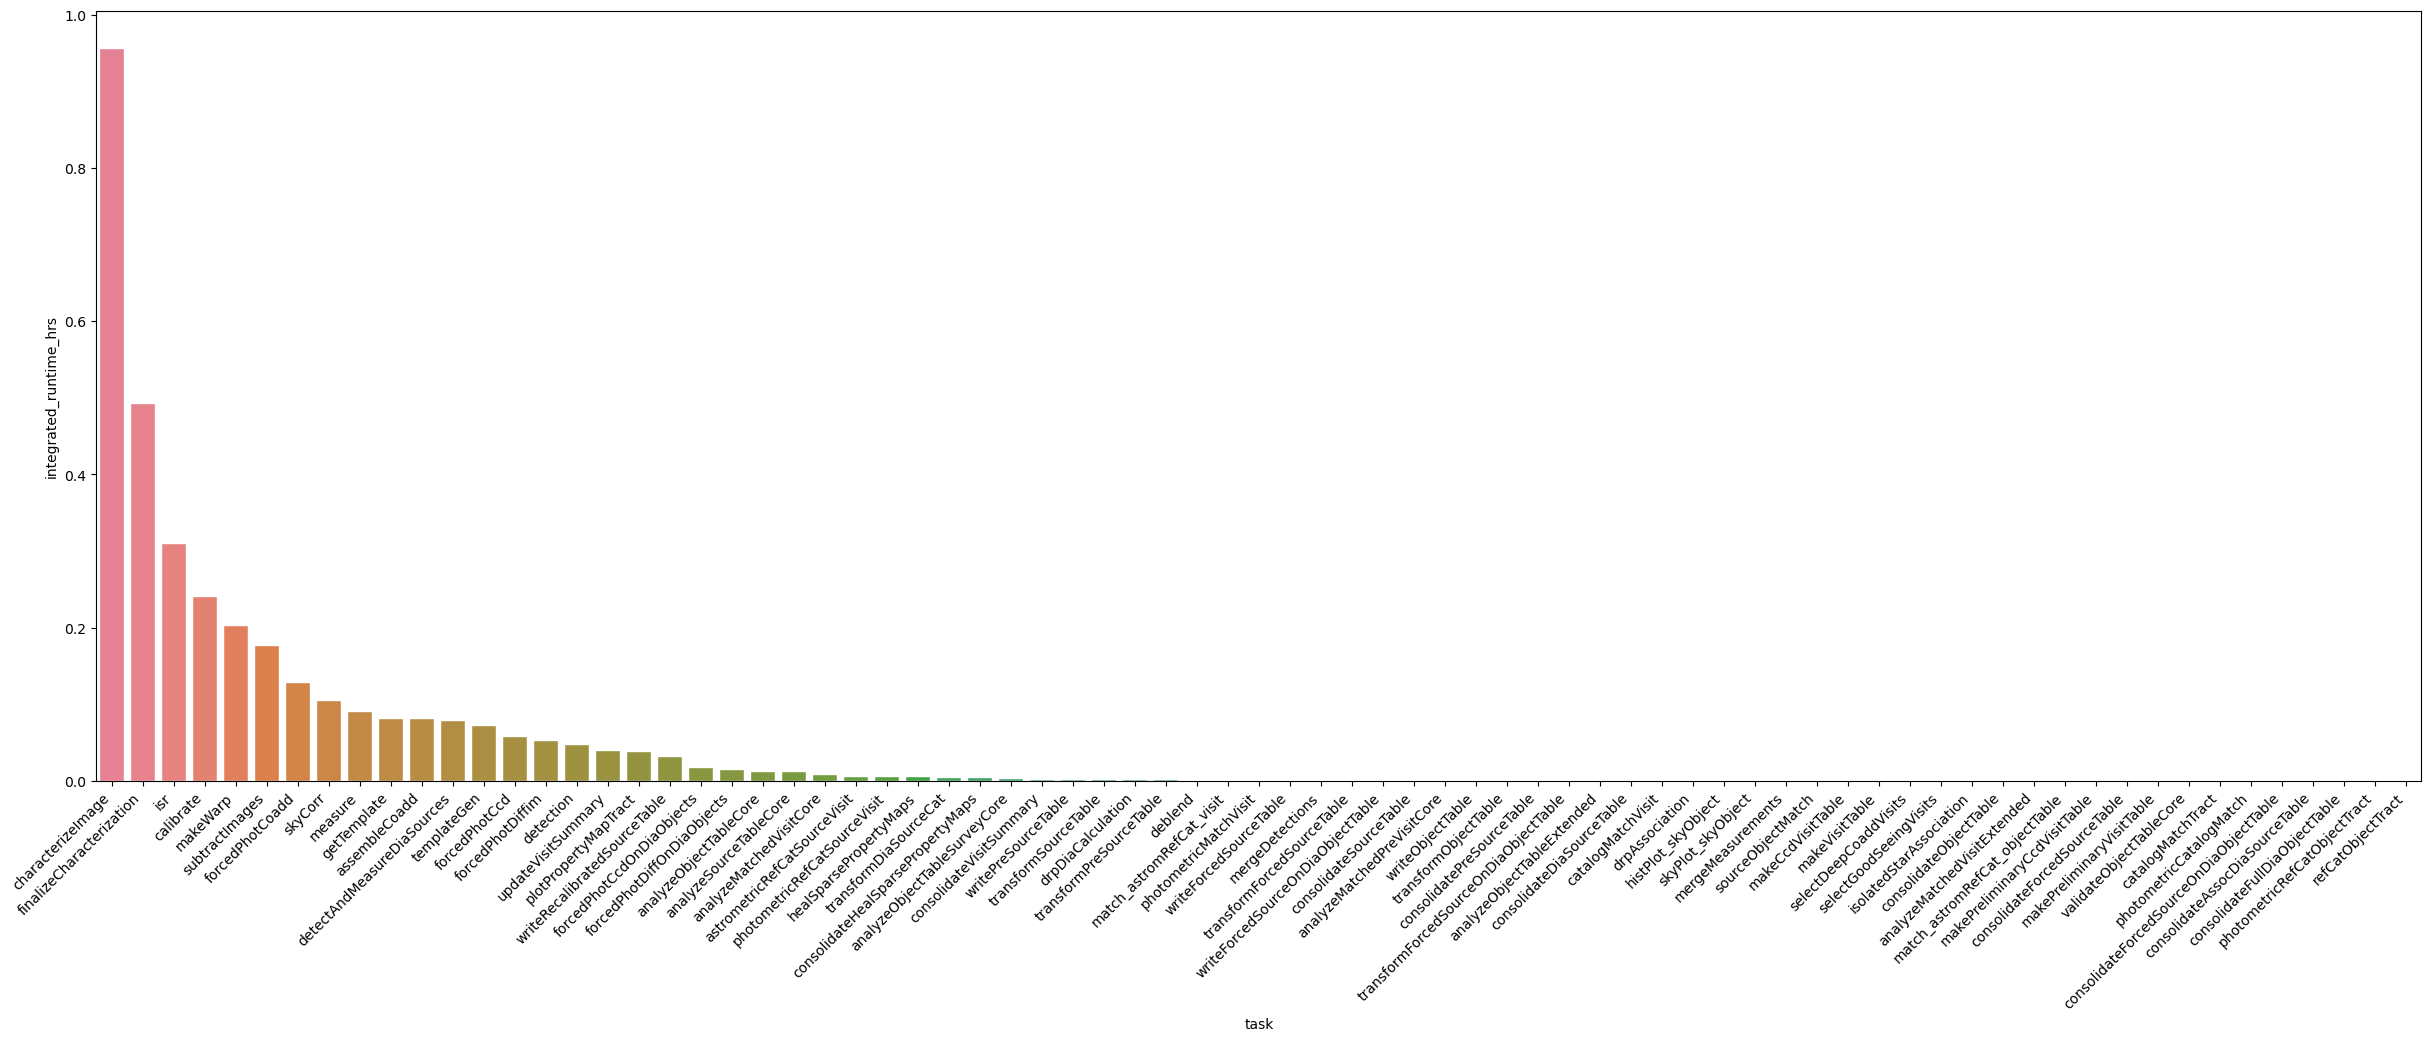

In [11]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.set(font_scale=1.5)
ax = sns.barplot(data=qq[~qq.task.str.startswith("plot_")].sort_values('integrated_runtime_hrs',ascending=False),
                 y="integrated_runtime_hrs", x="task",
                hue="task",
                )
ax.set_xticks(ax.get_xticks()) # To avoid a UserWarning
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
#plt.show()
plt.savefig('in.png')

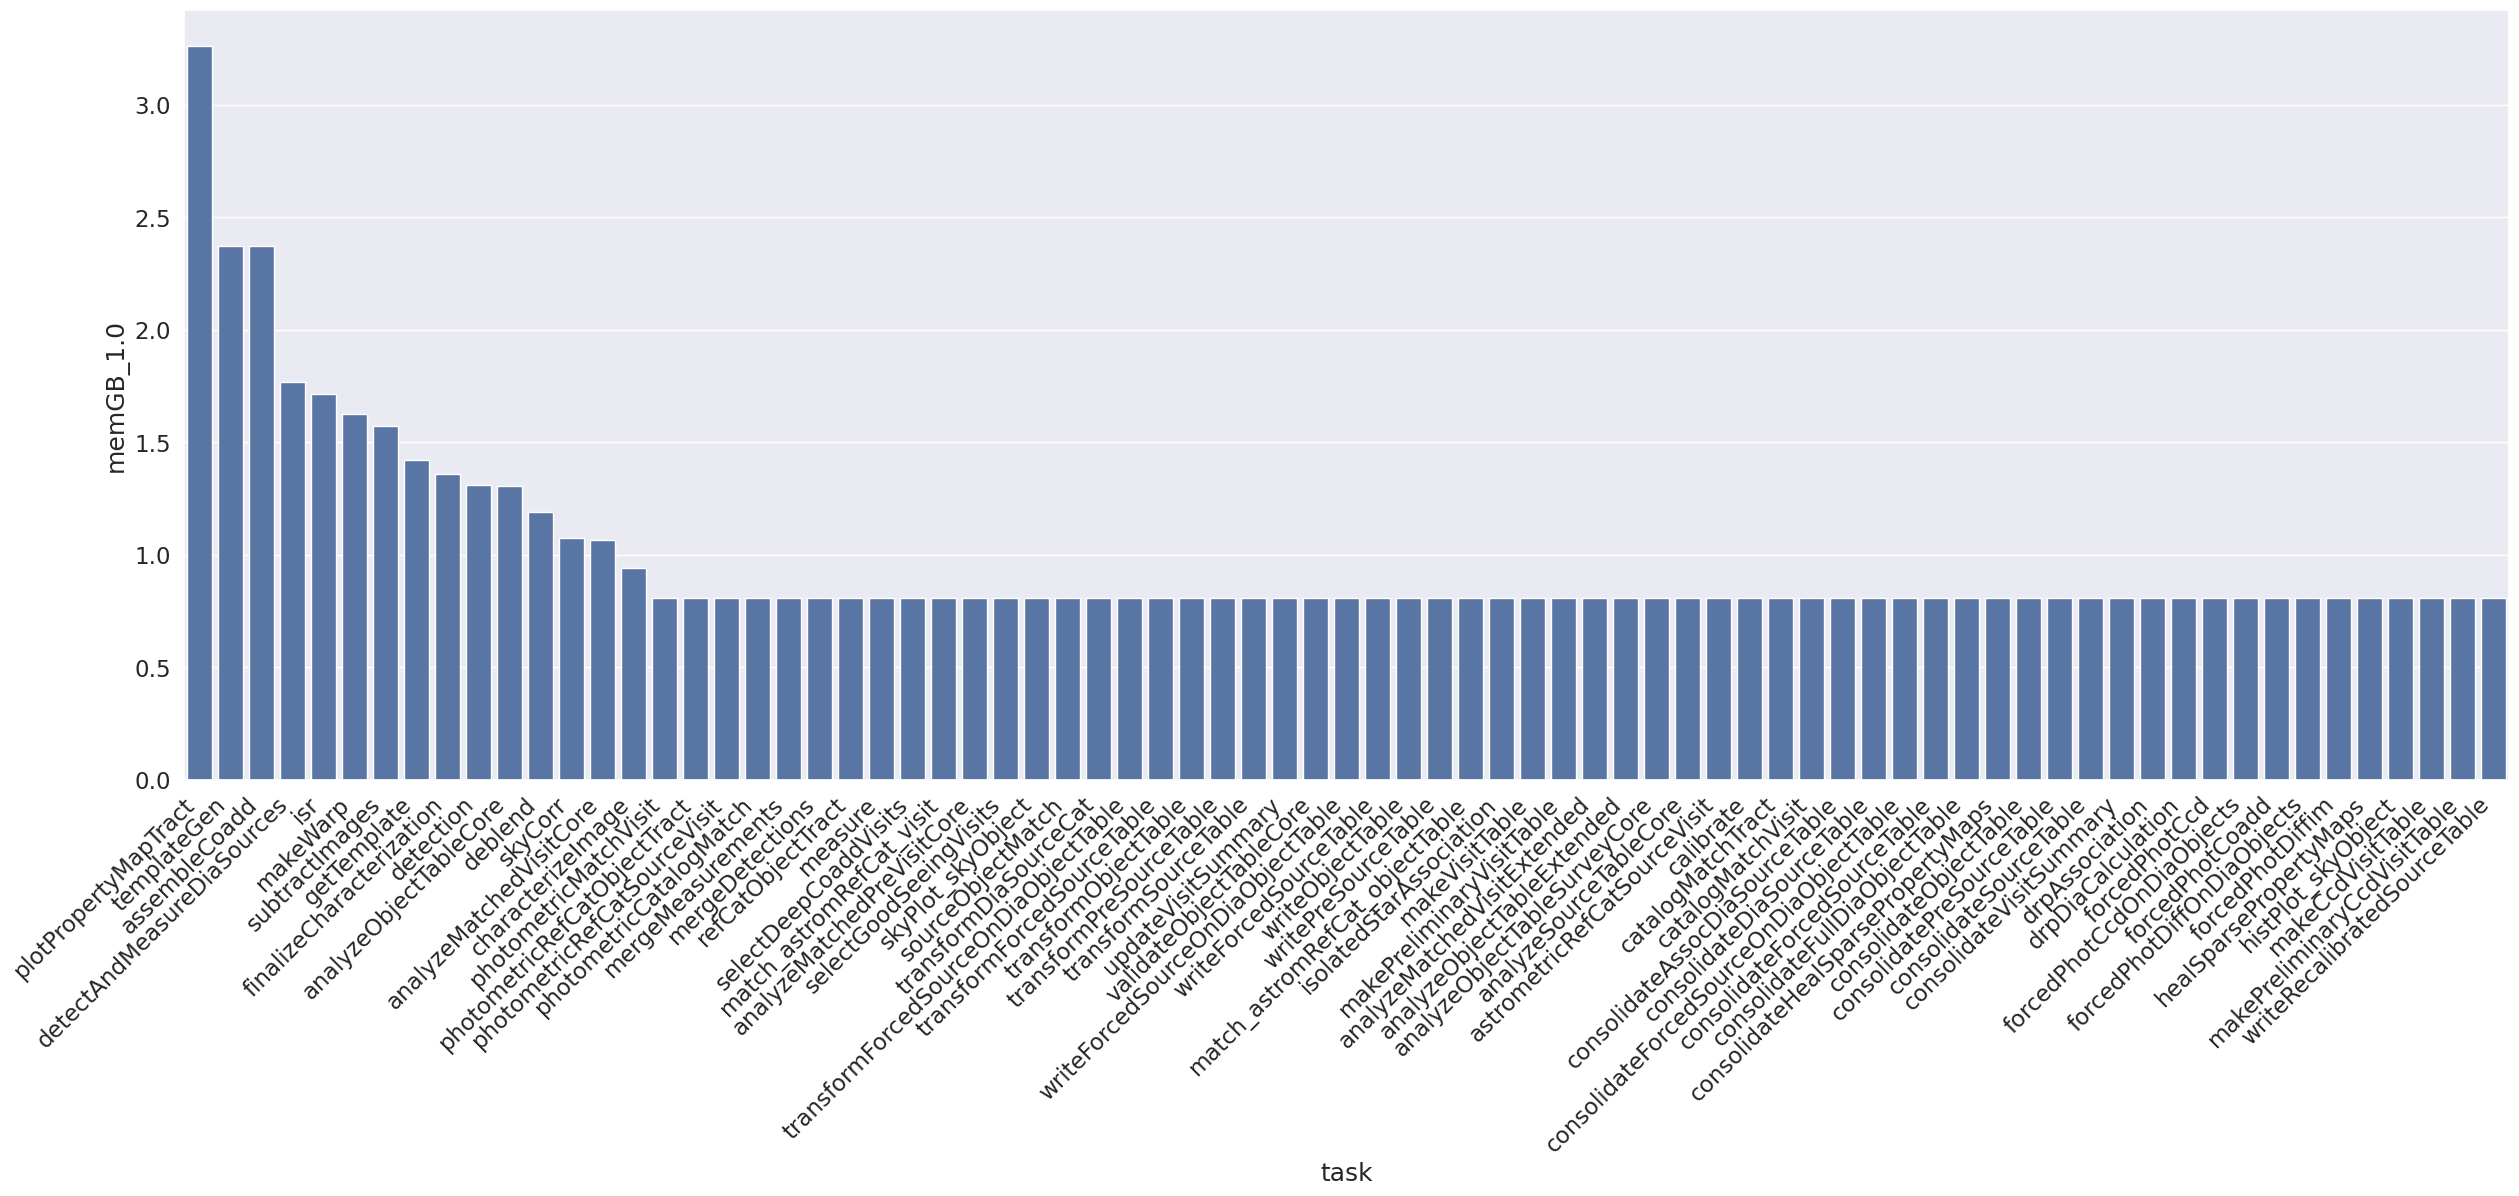

<Figure size 640x480 with 0 Axes>

In [12]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.set(font_scale=1.5)
ax = sns.barplot(data=memrun[~memrun.task.str.startswith("plot_")].sort_values('memGB_1.0',ascending=False), y="memGB_1.0", x="task")
ax.set_xticks(ax.get_xticks()) # To avoid a UserWarning
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()
plt.savefig('in.png')